<a href="https://colab.research.google.com/github/Rogerio-mack/fNIRS/blob/main/A_Carol_split_stim_3x8_24_one_subject.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Mount Google Drive

In [106]:
#@markdown
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## Common Imports

In [107]:
#@markdown 
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
# %matplotlib inline
import seaborn as sns

import h5py
from itertools import compress
from sklearn.preprocessing import scale
from google.colab import widgets

## Install & import `nilearn` and `mne-nirs`

In [108]:
%%script false
#@markdown
!pip install nilearn
!pip install -U --no-deps https://github.com/mne-tools/mne-python/archive/main.zip
!pip install mne-nirs

from mne.io import read_raw_nirx
from mne.preprocessing.nirs import (optical_density, beer_lambert_law,
                                    temporal_derivative_distribution_repair)
import mne 



# Routines

In [109]:
#@markdown `def clone_snirf(path_in, path_out, fname='out.snirf')`
def clone_snirf(path_in, path_out, fname='out.snirf'):
  
  if path_in == path_out:
    print('Error: path_in and path_out can not be the same.') 
    return

  if not os.path.exists(path_out):
      os.mkdir(path_out)
      print("Directory " , path_out ,  "was created")
  else:    
      print("Warning: directory " , path_out ,  " already exists")

  if os.path.exists(path_out + fname):
    os.remove(path_out + fname)
    print('Warning: previous output file was deleted.')
  
  print('Input snirf file: ' + path_in + fname)

  fs = h5py.File(path_in + fname,'r')
  fd = h5py.File(path_out + fname,'w')

  if list(fs.keys()).count('formatVersion') >= 1:
    fs.copy('formatVersion',fd,'formatVersion') 
  else:
    print('Warning: there is no formatVersion key in snirf input.')

  if list(fs.keys()).count('nirs') >= 1:
    fs.copy('nirs',fd,'nirs') 
  else:
    print('Error: Invalid snirf file. There is no nirs key in snirf input.')  
  
  print('Output snirf file: ' + path_out + fname)
  
  fd.close()
  fs.close()

  return

# Split Stimulus $3 \times 8 \rightarrow 24 $

---

Cria a partir dos estímulos $24$  estímulos $8 \times$ Sync,  $8 \times$ Async e  $8 \times$ controle, os estímulos  Sync1,..., Sync8, Async1, ...Async8, controle1, ..., controle8. 

In [110]:
import os
path_in = '/content/drive/MyDrive/Cond 2/'
path_out = '/content/snirf/'

os.listdir(path_in + 'snirf/')[0:5]

['26_run2.snirf',
 '14_run2.snirf',
 '19_run2.snirf',
 '31_run2.snirf',
 '3_run2.snirf']

In [111]:
fname = '31_run2.snirf'
clone_snirf(path_in + 'snirf/', path_out, fname=fname)

Input snirf file: /content/drive/MyDrive/Cond 2/snirf/31_run2.snirf
Output snirf file: /content/snirf/31_run2.snirf


In [112]:
data = h5py.File(path_out + fname,'r+')
#
# create alias for data['nirs']
#
for key in data['nirs'].keys():
  exp = key + ' = data["nirs"]["' + key + '"] '
#  print(exp)
  exec(exp)


In [113]:
print(data['nirs'].keys())

for s in ['stim1', 'stim3', 'stim01', 'stim02', 'stim03', 'stim04', 'stim05']:
  del data['nirs'][s]

print(data['nirs'].keys())

<KeysViewHDF5 ['aux1', 'aux2', 'aux3', 'aux4', 'aux5', 'aux6', 'aux7', 'aux8', 'data1', 'metaDataTags', 'probe', 'stim01', 'stim02', 'stim03', 'stim04', 'stim05', 'stim1', 'stim2', 'stim3', 'stim4', 'stim5']>
<KeysViewHDF5 ['aux1', 'aux2', 'aux3', 'aux4', 'aux5', 'aux6', 'aux7', 'aux8', 'data1', 'metaDataTags', 'probe', 'stim2', 'stim4', 'stim5']>


In [114]:
# rename
for s in ['stim2','stim4','stim5']:
#  data['nirs'].create_group(s + 'old') 
  data['nirs'].copy(s, 'old' + s)
  del data['nirs'][s]

print(data['nirs'].keys())
# print(data['nirs']['old' + s]['data'][:])

<KeysViewHDF5 ['aux1', 'aux2', 'aux3', 'aux4', 'aux5', 'aux6', 'aux7', 'aux8', 'data1', 'metaDataTags', 'oldstim2', 'oldstim4', 'oldstim5', 'probe']>
[[2.30e+02 1.00e+01 1.00e+00]
 [4.10e+02 1.00e+01 1.00e+00]
 [7.70e+02 1.00e+01 1.00e+00]
 [9.50e+02 1.00e+01 1.00e+00]
 [1.31e+03 1.00e+01 1.00e+00]
 [1.49e+03 1.00e+01 1.00e+00]
 [1.85e+03 1.00e+01 1.00e+00]
 [2.03e+03 1.00e+01 1.00e+00]]


In [115]:
labels = data['nirs']['oldstim2']['dataLabels'][:]

stim_nr = 1
for s in ['oldstim2','oldstim4','oldstim5']:
  for i in range(len(data['nirs'][s]['data'][:])):
    stim = 'stim' + str(stim_nr)
    data['nirs'].create_group(stim)
    data['nirs'][stim].create_dataset('name', data=np.array([data['nirs'][s]['name'][0].decode('UTF-8') + str(i+1)]).astype('|S10'))
    data['nirs'][stim].create_dataset('dataLabels', data=labels)
    data['nirs'][stim].create_dataset('data', data=data['nirs'][s]['data'][i][np.newaxis,:]) 
    stim_nr = stim_nr + 1 

print(data['nirs'].keys())
    

<KeysViewHDF5 ['aux1', 'aux2', 'aux3', 'aux4', 'aux5', 'aux6', 'aux7', 'aux8', 'data1', 'metaDataTags', 'oldstim2', 'oldstim4', 'oldstim5', 'probe', 'stim1', 'stim10', 'stim11', 'stim12', 'stim13', 'stim14', 'stim15', 'stim16', 'stim17', 'stim18', 'stim19', 'stim2', 'stim20', 'stim21', 'stim22', 'stim23', 'stim24', 'stim3', 'stim4', 'stim5', 'stim6', 'stim7', 'stim8', 'stim9']>


In [116]:
stim_list = [x for x in data['nirs'].keys() if ('stim' in x) and ('old' not in x)]
stim_names = []
stim_start = []

for s in stim_list:
  stim_names.append(data['nirs'][s]['name'][0].decode('utf8')) 
  stim_start.append(data['nirs'][s]['data'][:][0][0])

pd.DataFrame({'stim_names': stim_names, 'stim_start':stim_start},index=None).sort_values('stim_start') 

,stim_names,stim_start
0,Sync1,40.0
23,Async1,140.0
8,controle1,230.0
11,Sync2,320.0
9,controle2,410.0
1,Async2,500.0
17,Sync3,590.0
2,Async3,680.0
10,controle3,770.0
18,Sync4,860.0


In [117]:
del data['nirs']['oldstim2']
del data['nirs']['oldstim4']
del data['nirs']['oldstim5']

In [118]:
# data.close()

# Valida Split Stimulus
---
Aqui, uma série de validações dos estímulos criados, incluindo a tabela hemodinâmica de cada um dos estímulos.

## Retrieve one subject

In [119]:
path_out + fname

'/content/snirf/31_run2.snirf'

['31_run2.snirf']
Loading /content/snirf/31_run2.snirf
Reading 0 ... 21700  =      0.000 ...  2170.000 secs...


<ipython-input-120-66880b6c5a23>:18: RuntimeWarning: Negative intensities encountered. Setting to abs(x)
  raw_od = mne.preprocessing.nirs.optical_density(raw_intensity)


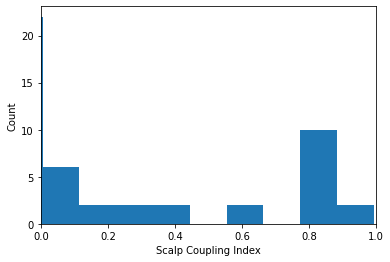

Effective window size : 204.800 (s)
Effective window size : 204.800 (s)


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished


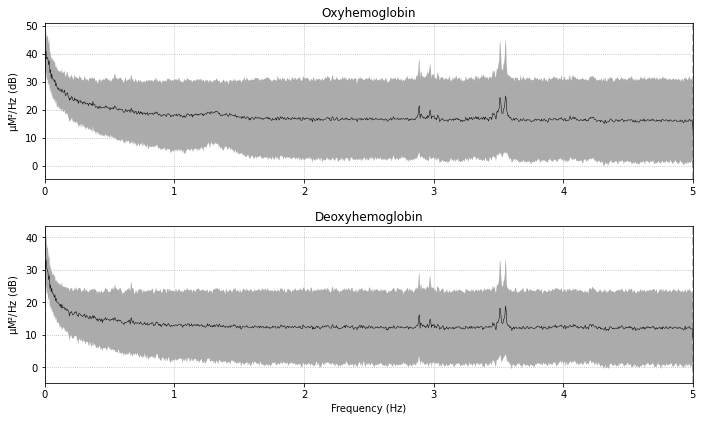

Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.05 - 0.7 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.05
- Lower transition bandwidth: 0.02 Hz (-6 dB cutoff frequency: 0.04 Hz)
- Upper passband edge: 0.70 Hz
- Upper transition bandwidth: 0.20 Hz (-6 dB cutoff frequency: 0.80 Hz)
- Filter length: 1651 samples (165.100 sec)

Effective window size : 204.800 (s)
Effective window size : 204.800 (s)


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  48 out of  48 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished


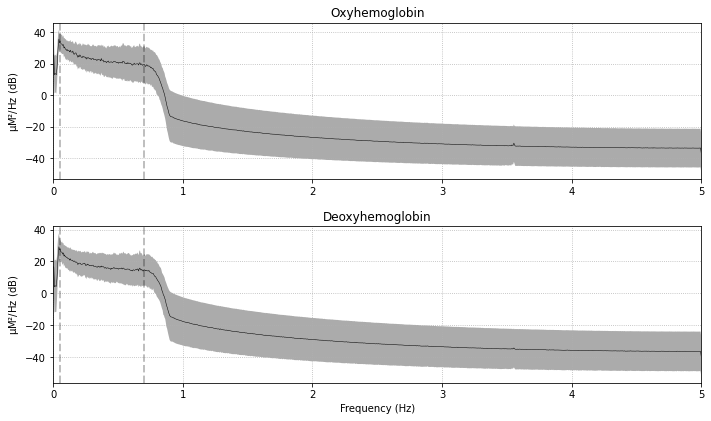

<Info | 9 non-empty values
 bads: []
 ch_names: S1_D1 hbo, S1_D1 hbr, S1_D8 hbo, S1_D8 hbr, S1_D14 hbo, S1_D14 ...
 chs: 24 Oxyhemoglobin, 24 Deoxyhemoglobin
 custom_ref_applied: False
 dig: 51 items (3 Cardinal, 48 EEG)
 highpass: 0.1 Hz
 lowpass: 0.7 Hz
 meas_date: 2021-12-09 10:12:29 UTC
 nchan: 48
 projs: []
 sfreq: 10.0 Hz
 subject_info: 1 item (dict)
>


/usr/local/lib/python3.7/dist-packages/matplotlib/colors.py:263: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  c = np.array(c)


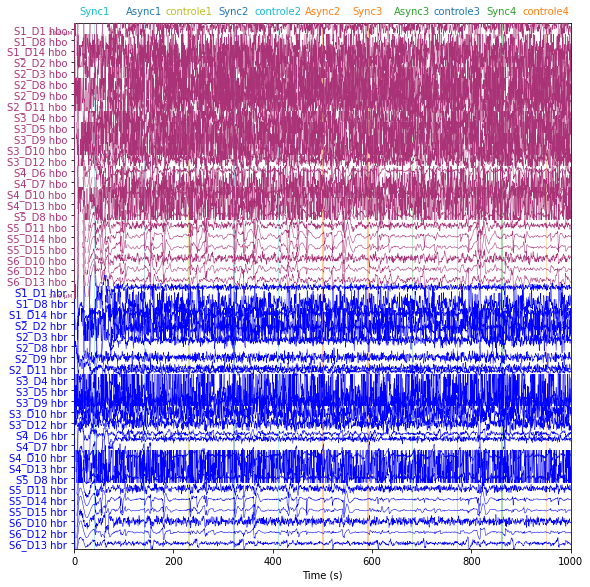

In [120]:
from mne.io import read_raw_nirx
from mne.preprocessing.nirs import (optical_density, beer_lambert_law,
                                    temporal_derivative_distribution_repair)
import mne
import pickle

entries = [fname]
print(entries)

sci_df_exists = False
sci_df = pd.DataFrame()

raw_haemo_all = {}

for fname in entries:
  raw_intensity = mne.io.read_raw_snirf(path_out + fname, verbose=True)
  raw_intensity.load_data()
  raw_od = mne.preprocessing.nirs.optical_density(raw_intensity)
  sci = mne.preprocessing.nirs.scalp_coupling_index(raw_od)
  
  fig, ax = plt.subplots()
  ax.hist(sci)
  ax.set(xlabel='Scalp Coupling Index', ylabel='Count', xlim=[0, 1])
  plt.show()
  
  # raw_od.info['bads'] = list(compress(raw_od.ch_names, sci < threshold))
  # raw_od.info['bads'] =  bad_list
  raw_haemo = mne.preprocessing.nirs.beer_lambert_law(raw_od)

  fig = raw_haemo.plot_psd(average=True)
  fig.suptitle('Before filtering', weight='bold', size='x-large')
  fig.subplots_adjust(top=0.88)
  raw_haemo = raw_haemo.filter(0.05, 0.7, h_trans_bandwidth=0.2,
                              l_trans_bandwidth=0.02)
  fig = raw_haemo.plot_psd(average=True)
  fig.suptitle('After filtering', weight='bold', size='x-large')
  fig.subplots_adjust(top=0.88)
  plt.show()

  print(raw_haemo.info)

  raw_haemo.plot(n_channels=48, duration=1000, show_scrollbars=False)
  plt.show()


    

## Check events

In [121]:
for i in range(len(raw_haemo.annotations[:][:])):
   print(raw_haemo.annotations[:][i]['description'].ljust(15),raw_haemo.annotations[:][i]['onset'])

Sync1           40.0
Async1          140.0
controle1       230.0
Sync2           320.0
controle2       410.0
Async2          500.0
Sync3           590.0
Async3          680.0
controle3       770.0
Sync4           860.0
controle4       950.0
Async4          1040.0
Sync5           1130.0
Async5          1220.0
controle5       1310.0
Sync6           1400.0
controle6       1490.0
Async6          1580.0
Sync7           1670.0
Async7          1760.0
controle7       1850.0
Sync8           1940.0
controle8       2030.0
Async8          2120.0


In [122]:
events, event_dictall = mne.events_from_annotations(raw_haemo)

Used Annotations descriptions: ['Async1', 'Async2', 'Async3', 'Async4', 'Async5', 'Async6', 'Async7', 'Async8', 'Sync1', 'Sync2', 'Sync3', 'Sync4', 'Sync5', 'Sync6', 'Sync7', 'Sync8', 'controle1', 'controle2', 'controle3', 'controle4', 'controle5', 'controle6', 'controle7', 'controle8']


In [123]:
event_dictall

{'Async1': 1,
 'Async2': 2,
 'Async3': 3,
 'Async4': 4,
 'Async5': 5,
 'Async6': 6,
 'Async7': 7,
 'Async8': 8,
 'Sync1': 9,
 'Sync2': 10,
 'Sync3': 11,
 'Sync4': 12,
 'Sync5': 13,
 'Sync6': 14,
 'Sync7': 15,
 'Sync8': 16,
 'controle1': 17,
 'controle2': 18,
 'controle3': 19,
 'controle4': 20,
 'controle5': 21,
 'controle6': 22,
 'controle7': 23,
 'controle8': 24}

In [124]:
syncs = [ ]
asyncs = [ ]

for i in range(len(list(event_dictall)[16:24])):
  asyncs.append([ list(event_dictall)[i], list(event_dictall)[i+16] ]) 
  syncs.append([ list(event_dictall)[i+8], list(event_dictall)[i+16] ]) 

allstim = syncs + asyncs
allstim


[['Sync1', 'controle1'],
 ['Sync2', 'controle2'],
 ['Sync3', 'controle3'],
 ['Sync4', 'controle4'],
 ['Sync5', 'controle5'],
 ['Sync6', 'controle6'],
 ['Sync7', 'controle7'],
 ['Sync8', 'controle8'],
 ['Async1', 'controle1'],
 ['Async2', 'controle2'],
 ['Async3', 'controle3'],
 ['Async4', 'controle4'],
 ['Async5', 'controle5'],
 ['Async6', 'controle6'],
 ['Async7', 'controle7'],
 ['Async8', 'controle8']]

<ipython-input-125-a16cda1d9cff>:3: RuntimeWarning: More events than default colors available. You should pass a list of unique colors.
  sfreq=raw_haemo.info['sfreq'])


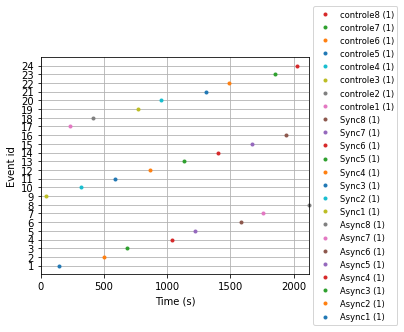

In [125]:
event_dict = event_dictall
fig = mne.viz.plot_events(events, event_id=event_dict,
                          sfreq=raw_haemo.info['sfreq'])
fig.subplots_adjust(right=0.7)  # make room for the legend

## Curva Hemodinâmica

In [126]:
events, _ = mne.events_from_annotations(raw_haemo)

event_dict = {'Sync1': 9, 'controle1': 17}

reject_criteria = dict(hbo=80e-6)
tmin, tmax = -8, 15

epochs = mne.Epochs(raw_haemo, events, event_id=event_dict,
                    tmin=tmin, tmax=tmax,
#                    reject=reject_criteria, reject_by_annotation=True,
                    proj=True, baseline=(None, 0), preload=True,
                    detrend=None, verbose=True,
                    event_repeated='merge') # ADICIONADO Allowed values are 'error', 'drop', and 'merge'
# epochs.plot_drop_log()

Used Annotations descriptions: ['Async1', 'Async2', 'Async3', 'Async4', 'Async5', 'Async6', 'Async7', 'Async8', 'Sync1', 'Sync2', 'Sync3', 'Sync4', 'Sync5', 'Sync6', 'Sync7', 'Sync8', 'controle1', 'controle2', 'controle3', 'controle4', 'controle5', 'controle6', 'controle7', 'controle8']
Not setting metadata
2 matching events found
Setting baseline interval to [-8.0, 0.0] sec
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 2 events and 231 original time points ...
0 bad epochs dropped


In [127]:
for s, c in allstim:
  event_dict = {}
  event_dict[s] = event_dictall[s]
  event_dict[c] = event_dictall[c]

event_dict 

{'Async8': 8, 'controle8': 24}

In [128]:
events, event_dict = mne.events_from_annotations(raw_haemo)

reject_criteria = dict(hbo=80e-6)
tmin, tmax = -8, 15

epochs = mne.Epochs(raw_haemo, events, event_id=event_dict,
                    tmin=tmin, tmax=tmax,
#                    reject=reject_criteria, reject_by_annotation=True,
                    proj=True, baseline=(None, 0), preload=True,
                    detrend=None, verbose=True,
                    event_repeated='merge') 

df_epochs = epochs.to_data_frame()
df_epochs.head()

Used Annotations descriptions: ['Async1', 'Async2', 'Async3', 'Async4', 'Async5', 'Async6', 'Async7', 'Async8', 'Sync1', 'Sync2', 'Sync3', 'Sync4', 'Sync5', 'Sync6', 'Sync7', 'Sync8', 'controle1', 'controle2', 'controle3', 'controle4', 'controle5', 'controle6', 'controle7', 'controle8']
Not setting metadata
24 matching events found
Setting baseline interval to [-8.0, 0.0] sec
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 24 events and 231 original time points ...
0 bad epochs dropped


,time,condition,epoch,S1_D1 hbo,S1_D1 hbr,S1_D8 hbo,S1_D8 hbr,S1_D14 hbo,S1_D14 hbr,S2_D2 hbo,...,S5_D14 hbo,S5_D14 hbr,S5_D15 hbo,S5_D15 hbr,S6_D10 hbo,S6_D10 hbr,S6_D12 hbo,S6_D12 hbr,S6_D13 hbo,S6_D13 hbr
0,-8000,Sync1,0,-223.095813,-95.209982,-273.987090,29.901112,-25.440037,3.523207,-35.473964,...,-16.926312,-6.900637,-15.423590,-8.153822,-6.596089,-2.915319,-11.387190,-4.095597,-16.014399,-2.624138
1,-7900,Sync1,0,-213.342617,-90.484306,-260.740502,27.556084,-34.233264,4.873988,-32.292350,...,-16.301396,-6.675716,-14.929899,-7.814099,-6.552766,-2.388765,-11.030815,-3.803279,-15.609299,-2.293011
2,-7800,Sync1,0,-203.747805,-85.851103,-246.859288,24.263349,-38.752266,5.283469,-30.670418,...,-15.656000,-6.480273,-14.434276,-7.488515,-6.810224,-1.627248,-10.662901,-3.533961,-15.097668,-2.073870
3,-7700,Sync1,0,-194.361051,-81.274220,-232.484086,20.139458,-38.191068,4.686372,-30.177275,...,-15.006020,-6.302695,-13.937044,-7.184114,-7.251591,-0.733167,-10.263648,-3.304283,-14.453755,-1.996500
4,-7600,Sync1,0,-185.189898,-76.740185,-217.879421,15.477892,-32.570927,3.195601,-30.233786,...,-14.367035,-6.132333,-13.438918,-6.904544,-7.728798,0.157902,-9.821741,-3.123780,-13.680172,-2.065243


In [129]:
df_hbo_cols = [x for x in df_epochs.columns if 'hbo' in x]
df_hbr_cols = [x for x in df_epochs.columns if 'hbr' in x]

In [130]:
df_epochs['mHBO'] = df_epochs[ df_hbo_cols ].mean(axis=1)
df_epochs['mHBR'] = df_epochs[ df_hbr_cols ].mean(axis=1)

In [131]:
df_epochs.condition.value_counts()

Sync1        231
Async1       231
controle8    231
Sync8        231
controle7    231
Async7       231
Sync7        231
Async6       231
controle6    231
Sync6        231
controle5    231
Async5       231
Sync5        231
Async4       231
controle4    231
Sync4        231
controle3    231
Async3       231
Sync3        231
Async2       231
controle2    231
Sync2        231
controle1    231
Async8       231
Name: condition, dtype: int64

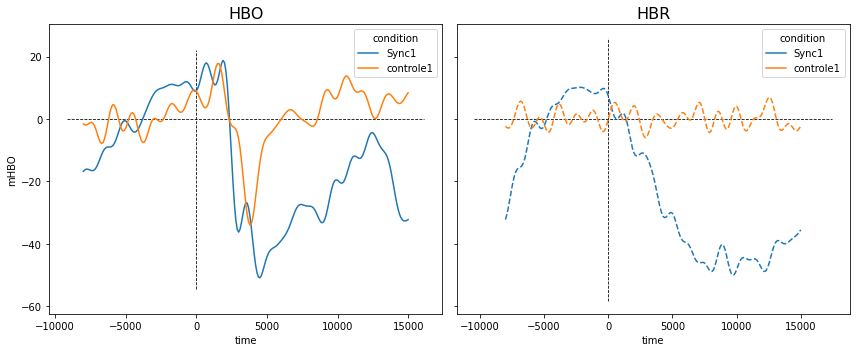

In [148]:
fig, ax = plt.subplots(1,2, figsize=(12,5),sharey=True)

sns.lineplot(x='time', y='mHBO', 
             hue='condition', 
             data=df_epochs[ (df_epochs.condition == 'Sync1') | (df_epochs.condition == 'controle1') ], ax=ax[0])
sns.lineplot(x='time', y='mHBR', 
             hue='condition', 
             data=df_epochs[ (df_epochs.condition == 'Sync1') | (df_epochs.condition == 'controle1') ], ax=ax[1], linestyle='--')


ax[0].vlines(0,ax[0].get_ylim()[0],ax[0].get_ylim()[1],linestyles='--',color='k',lw=0.8)
ax[0].hlines(0,ax[0].get_xlim()[0],ax[0].get_xlim()[1],linestyles='--',color='k',lw=0.8)
ax[1].vlines(0,ax[0].get_ylim()[0],ax[0].get_ylim()[1],linestyles='--',color='k',lw=0.8)
ax[1].hlines(0,ax[0].get_xlim()[0],ax[0].get_xlim()[1],linestyles='--',color='k',lw=0.8)

ax[0].set_title('HBO', fontsize=16)
ax[1].set_title('HBR', fontsize=16)

plt.tight_layout()
plt.show()

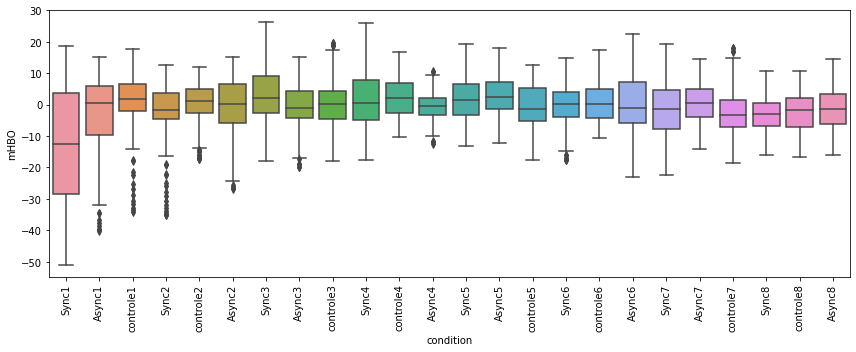

In [137]:
fig, ax = plt.subplots(1,1, figsize=(12,5))

sns.boxplot(x='condition', y='mHBO', data=df_epochs, ax=ax)
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

Used Annotations descriptions: ['Async1', 'Async2', 'Async3', 'Async4', 'Async5', 'Async6', 'Async7', 'Async8', 'Sync1', 'Sync2', 'Sync3', 'Sync4', 'Sync5', 'Sync6', 'Sync7', 'Sync8', 'controle1', 'controle2', 'controle3', 'controle4', 'controle5', 'controle6', 'controle7', 'controle8']
Not setting metadata
2 matching events found
Setting baseline interval to [-8.0, 0.0] sec
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 2 events and 231 original time points ...
0 bad epochs dropped
combining channels using "mean"
combining channels using "mean"
combining channels using "mean"
combining channels using "mean"


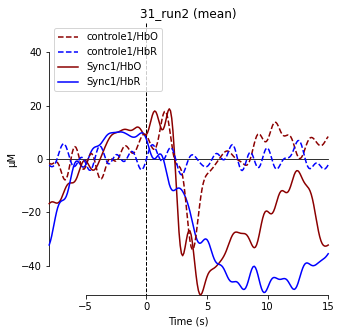

Not setting metadata
2 matching events found
Setting baseline interval to [-8.0, 0.0] sec
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 2 events and 231 original time points ...
0 bad epochs dropped
combining channels using "mean"
combining channels using "mean"
combining channels using "mean"
combining channels using "mean"


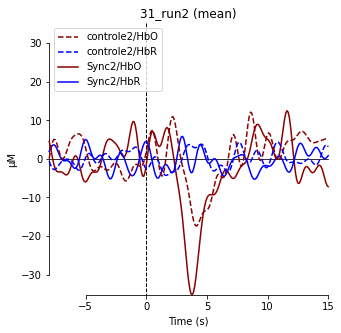

Not setting metadata
2 matching events found
Setting baseline interval to [-8.0, 0.0] sec
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 2 events and 231 original time points ...
0 bad epochs dropped
combining channels using "mean"
combining channels using "mean"
combining channels using "mean"
combining channels using "mean"


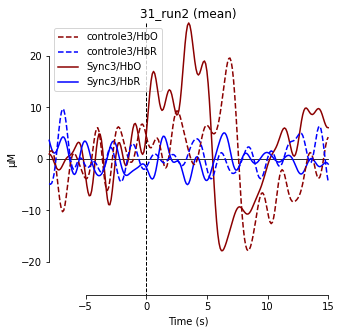

Not setting metadata
2 matching events found
Setting baseline interval to [-8.0, 0.0] sec
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 2 events and 231 original time points ...
0 bad epochs dropped
combining channels using "mean"
combining channels using "mean"
combining channels using "mean"
combining channels using "mean"


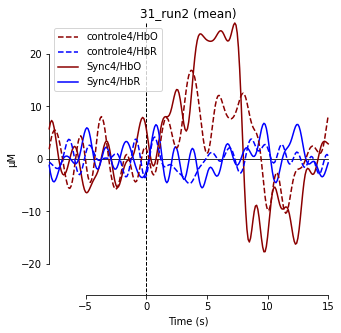

Not setting metadata
2 matching events found
Setting baseline interval to [-8.0, 0.0] sec
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 2 events and 231 original time points ...
0 bad epochs dropped
combining channels using "mean"
combining channels using "mean"
combining channels using "mean"
combining channels using "mean"


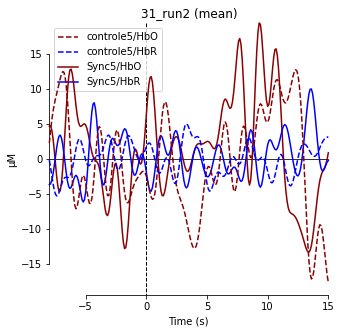

Not setting metadata
2 matching events found
Setting baseline interval to [-8.0, 0.0] sec
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 2 events and 231 original time points ...
0 bad epochs dropped
combining channels using "mean"
combining channels using "mean"
combining channels using "mean"
combining channels using "mean"


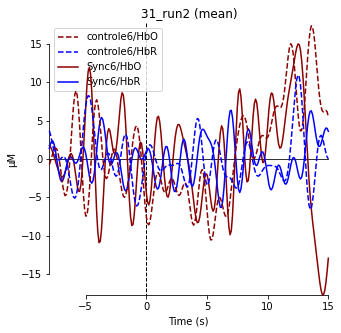

Not setting metadata
2 matching events found
Setting baseline interval to [-8.0, 0.0] sec
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 2 events and 231 original time points ...
0 bad epochs dropped
combining channels using "mean"
combining channels using "mean"
combining channels using "mean"
combining channels using "mean"


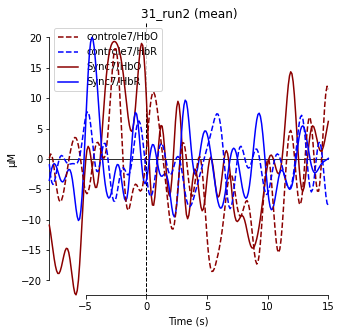

Not setting metadata
2 matching events found
Setting baseline interval to [-8.0, 0.0] sec
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 2 events and 231 original time points ...
0 bad epochs dropped
combining channels using "mean"
combining channels using "mean"
combining channels using "mean"
combining channels using "mean"


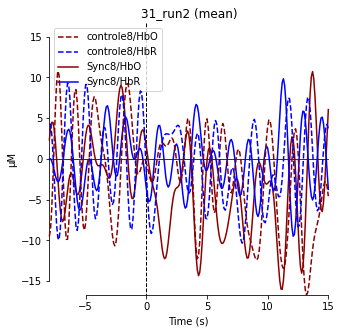

Not setting metadata
2 matching events found
Setting baseline interval to [-8.0, 0.0] sec
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 2 events and 231 original time points ...
0 bad epochs dropped
combining channels using "mean"
combining channels using "mean"
combining channels using "mean"
combining channels using "mean"


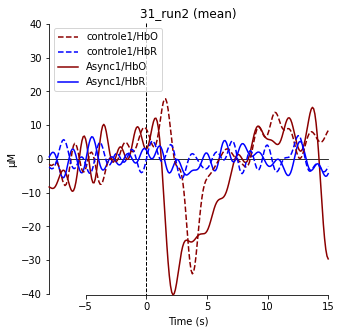

Not setting metadata
2 matching events found
Setting baseline interval to [-8.0, 0.0] sec
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 2 events and 231 original time points ...
0 bad epochs dropped
combining channels using "mean"
combining channels using "mean"
combining channels using "mean"
combining channels using "mean"


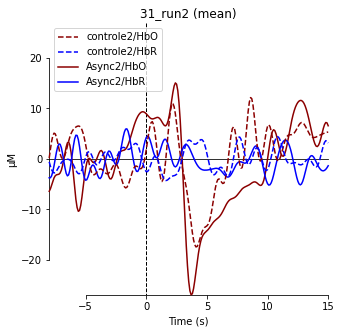

Not setting metadata
2 matching events found
Setting baseline interval to [-8.0, 0.0] sec
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 2 events and 231 original time points ...
0 bad epochs dropped
combining channels using "mean"
combining channels using "mean"
combining channels using "mean"
combining channels using "mean"


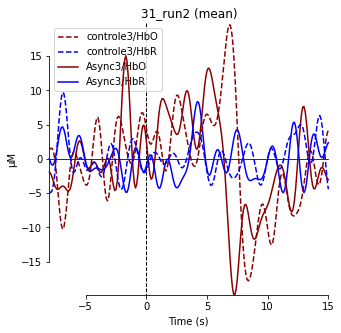

Not setting metadata
2 matching events found
Setting baseline interval to [-8.0, 0.0] sec
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 2 events and 231 original time points ...
0 bad epochs dropped
combining channels using "mean"
combining channels using "mean"
combining channels using "mean"
combining channels using "mean"


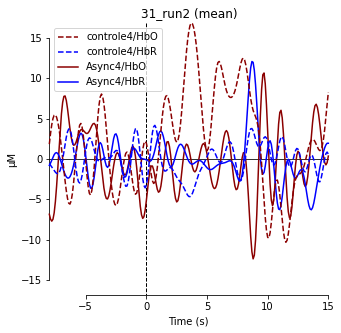

Not setting metadata
2 matching events found
Setting baseline interval to [-8.0, 0.0] sec
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 2 events and 231 original time points ...
0 bad epochs dropped
combining channels using "mean"
combining channels using "mean"
combining channels using "mean"
combining channels using "mean"


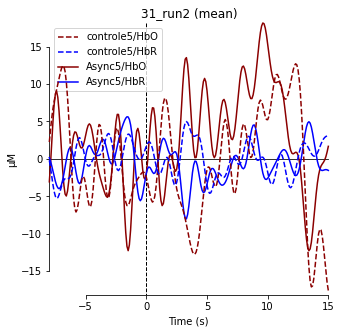

Not setting metadata
2 matching events found
Setting baseline interval to [-8.0, 0.0] sec
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 2 events and 231 original time points ...
0 bad epochs dropped
combining channels using "mean"
combining channels using "mean"
combining channels using "mean"
combining channels using "mean"


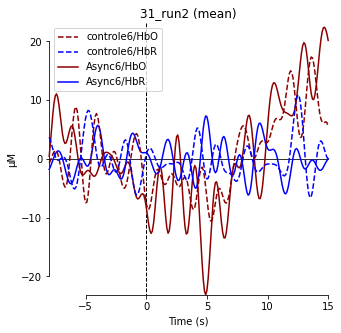

Not setting metadata
2 matching events found
Setting baseline interval to [-8.0, 0.0] sec
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 2 events and 231 original time points ...
0 bad epochs dropped
combining channels using "mean"
combining channels using "mean"
combining channels using "mean"
combining channels using "mean"


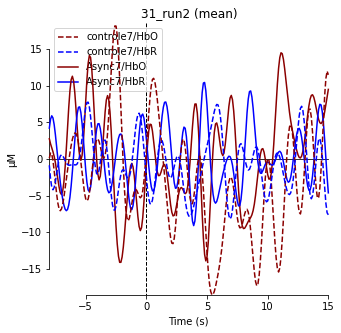

Not setting metadata
2 matching events found
Setting baseline interval to [-8.0, 0.0] sec
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 2 events and 231 original time points ...
0 bad epochs dropped
combining channels using "mean"
combining channels using "mean"
combining channels using "mean"
combining channels using "mean"


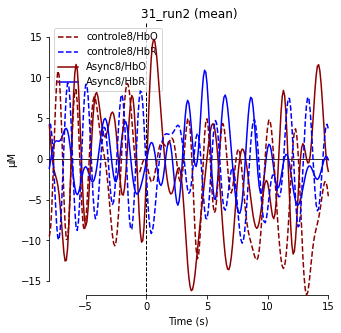

In [134]:
events, _ = mne.events_from_annotations(raw_haemo)

for s, c in allstim:
  event_dict = {}
  event_dict[s] = event_dictall[s]
  event_dict[c] = event_dictall[c]

  reject_criteria = dict(hbo=80e-6)
  tmin, tmax = -8, 15

  epochs = mne.Epochs(raw_haemo, events, event_id=event_dict,
                      tmin=tmin, tmax=tmax,
  #                    reject=reject_criteria, reject_by_annotation=True,
                      proj=True, baseline=(None, 0), preload=True,
                      detrend=None, verbose=True,
                      event_repeated='merge') # ADICIONADO Allowed values are 'error', 'drop', and 'merge'
  # epochs.plot_drop_log()

  evoked_dict = {s + '/HbO': epochs[s].average(picks='hbo'),
                s + '/HbR': epochs[s].average(picks='hbr'),
                c + '/HbO': epochs[c].average(picks='hbo'),
                c + '/HbR': epochs[c].average(picks='hbr')}

  color_dict = dict(HbO='darkred', HbR='b')
  styles_dict = {}
  styles_dict[c + '/HbO'] = dict(linestyle='dashed')
  styles_dict[c + '/HbR'] = dict(linestyle='dashed')

  subject = fname.split('.')[0]
  fig, ax = plt.subplots(1,1,figsize=(5,5))

  # Rename channels until the encoding of frequency in ch_name is fixed
  for condition in evoked_dict:
      evoked_dict[condition].rename_channels(lambda x: x[:-4]) # retira hbo e hbr do suffixo dos nomes      
  # print(evoked_dict)

  fig1 = mne.viz.plot_compare_evokeds(evoked_dict, combine="mean", ci=0.95,
                                colors=color_dict, styles=styles_dict, axes=ax, title=subject, show=False)

  fig1[0].savefig(fname.split('.')[0]+'_Sync.png')
  plt.show()

     